#  Análise Bayesiana dos parâmetros

In [1]:
%matplotlib inline
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano
import torch
plt.style.use('seaborn-darkgrid')

In [2]:
def model(y,t,p):
            ds = -p[1]*(1-p[3])*y[0]*y[2] + p[7]*y[5]#  dS/dt
            #chi*S, #dQ/dt Quarentenados acumulados
            de = p[1]*(1-p[3])*y[0]*y[2] - (p[5])*y[1] #dE/dt
            di =(1-p[4])*p[5]*y[1] - p[2]*y[2] - p[0]*y[2]# dI/dt
            da = p[4]*p[5]*y[1] - p[6]*y[3] #dA/dt
            dm = p[2]*y[2] #dM/dt Mortes acumuladas
            dr = p[0]*y[2] + p[6]*y[3] - p[7]*y[5]#dR/dt
            return [ds,de,di,da,dm,dr]

In [3]:
#parâmetros
alpha=1.189690427951546
beta=1.4665142574127266
chi=0.45884183441225135
delta=1.526261148108775
gamma=0.022444946411376093
rho=0.07339657298664196
theta=0.8514414610016147
mu=0
p=[rho,beta,gamma,chi,alpha,theta,delta,mu]
times = np.arange(0,5,0.25)

In [4]:
#definindo o SEIAMRQ model na classe differentialequation do PyMC3

seiamrq_model = DifferentialEquation(func=model, times=np.arange(0.25,5.25,0.25),
                                    n_states=6, n_theta=8, t0=0)

In [10]:
times=np.arange(0.25,5.25,0.25)
times

array([0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 , 2.75,
       3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])

In [5]:
y = odeint(model, t=times, y0=[0.99,0,0.01,0,0,0] , args=tuple([[rho,beta,gamma,chi,alpha,theta,delta,mu]]), rtol=1e-2)
yobs = np.random.lognormal(y,1)

In [6]:

with pm.Model() as model4:
    beta = pm.HalfCauchy('beta', 1, shape=6)

    # Distribuições a priori
    rho = pm.Lognormal('rho', pm.math.log(2), 2)
    theta = pm.Deterministic('theta', rho*beta )

    seiamrq_curves = seiamrq_model(y0=[0.99,0, 0.01,0,0,0], theta=p)

    Y = pm.Lognormal('Y', mu=pm.math.log(seiamrq_curves), sigma=beta, observed=yobs)
    #db = pm.backends.HDF5('traces.h5') # Salva as amostras e assim evita de manter tudo na memória
    trace = pm.sample(2000, tune=1000)#, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho, beta]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


In [7]:
data = az.from_pymc3(trace=trace)
data

/home/victor/.local/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

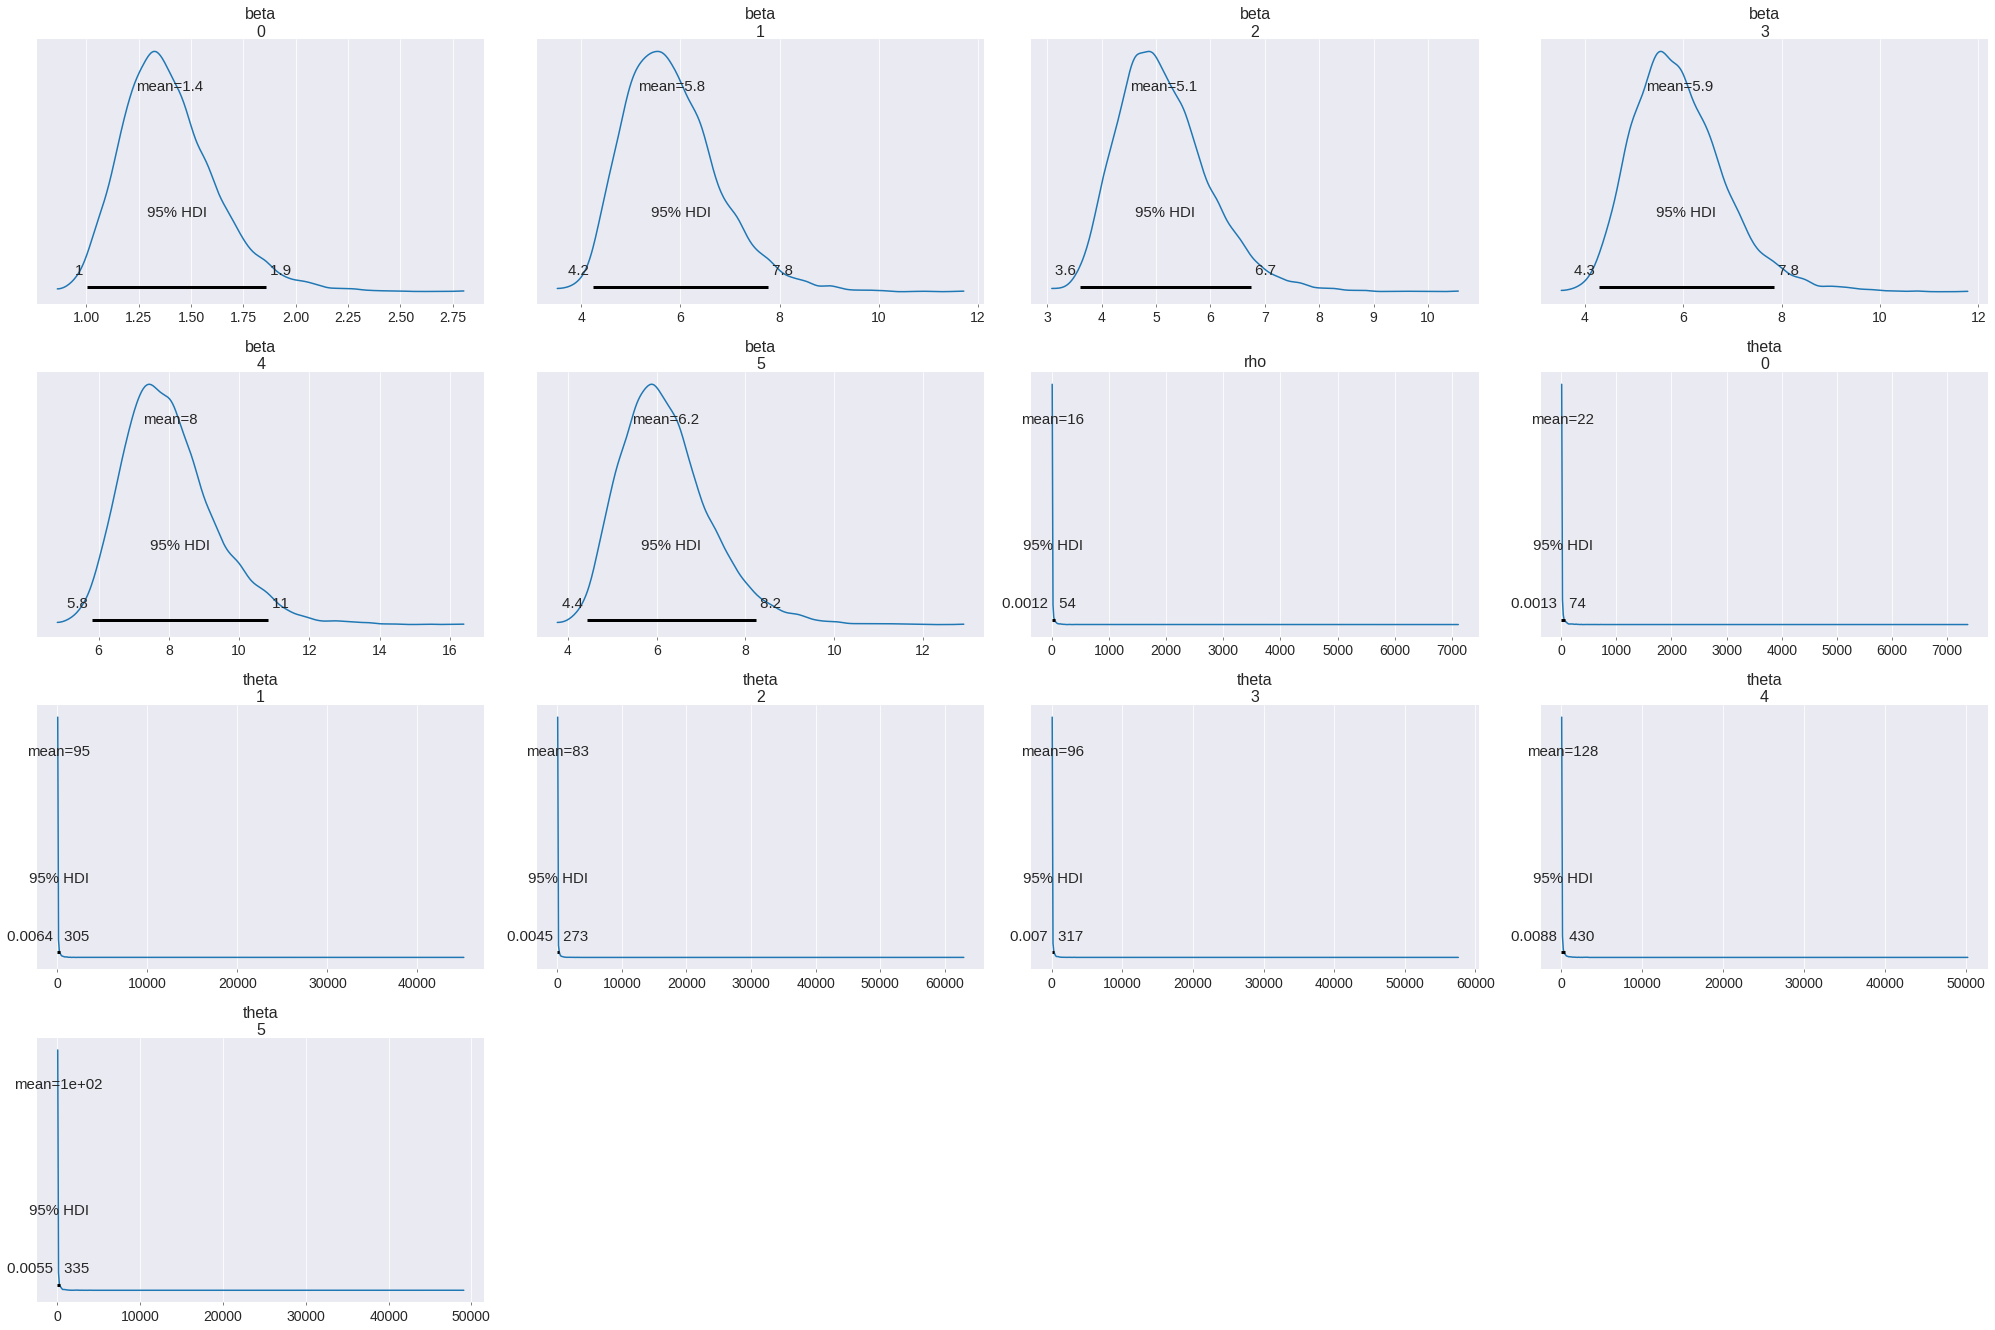

In [8]:
az.plot_posterior(data, round_to=2, hdi_prob=0.95);